<a href="https://colab.research.google.com/github/Oshgig/FRAUD-DETECTION/blob/main/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tensorflow keras scikeras -y



Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1


In [2]:
!pip install tensorflow==2.15.0 keras==2.15.0 scikeras==0.10.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
ERROR: pip's dependency resolver does no

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## IMPORT STATEMENT FROM PYTHON LIBRARIES

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string
import missingno as msno


from scipy.io import arff
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import regularizers


import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

from typing import List, Tuple

**IMPORT THE DATASET**

In [5]:
#Convert the arff file extension to a csv extension

def arff_to_csv(arff_file_path, csv_file_path):
    data, meta = arff.loadarff(arff_file_path)

    # Create DataFrame from the ARFF data
    df = pd.DataFrame(data)

    # Save the DataFrame
    df.to_csv(csv_file_path, index=False)



In [6]:
# call the function and load the path
arff_file_path = '/content/drive/MyDrive/LLM/phpKo8OWT.arff'
csv_file_path = '/content/drive/Othercomputers/My Mac/Desktop/project_code/fraud.csv'
arff_to_csv(arff_file_path, csv_file_path)


In [7]:
#Create a variable and read the csv file
df = pd.read_csv('/content/drive/Othercomputers/My Mac/Desktop/project_code/fraud.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,b'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,b'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,b'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,b'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,b'0'


# **DATA CLEANING**



In [8]:
#show the unique value of the class column
df['Class'].unique()

array(["b'0'", "b'1'"], dtype=object)

In [9]:
# Convert the Class unique value to an integer with replace function
df['Class'] = df['Class'].replace({"b'0'": 0, "b'1'": 1})
df['Class'].dtype

dtype('int64')

In [10]:
# Count the occurrences of fraud and no fraud and print them
#shows an high imbalance in the data
#where 0 is not_fraud and 1 is fraud
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [11]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# EXPLORATORY DATA ANALYSIS

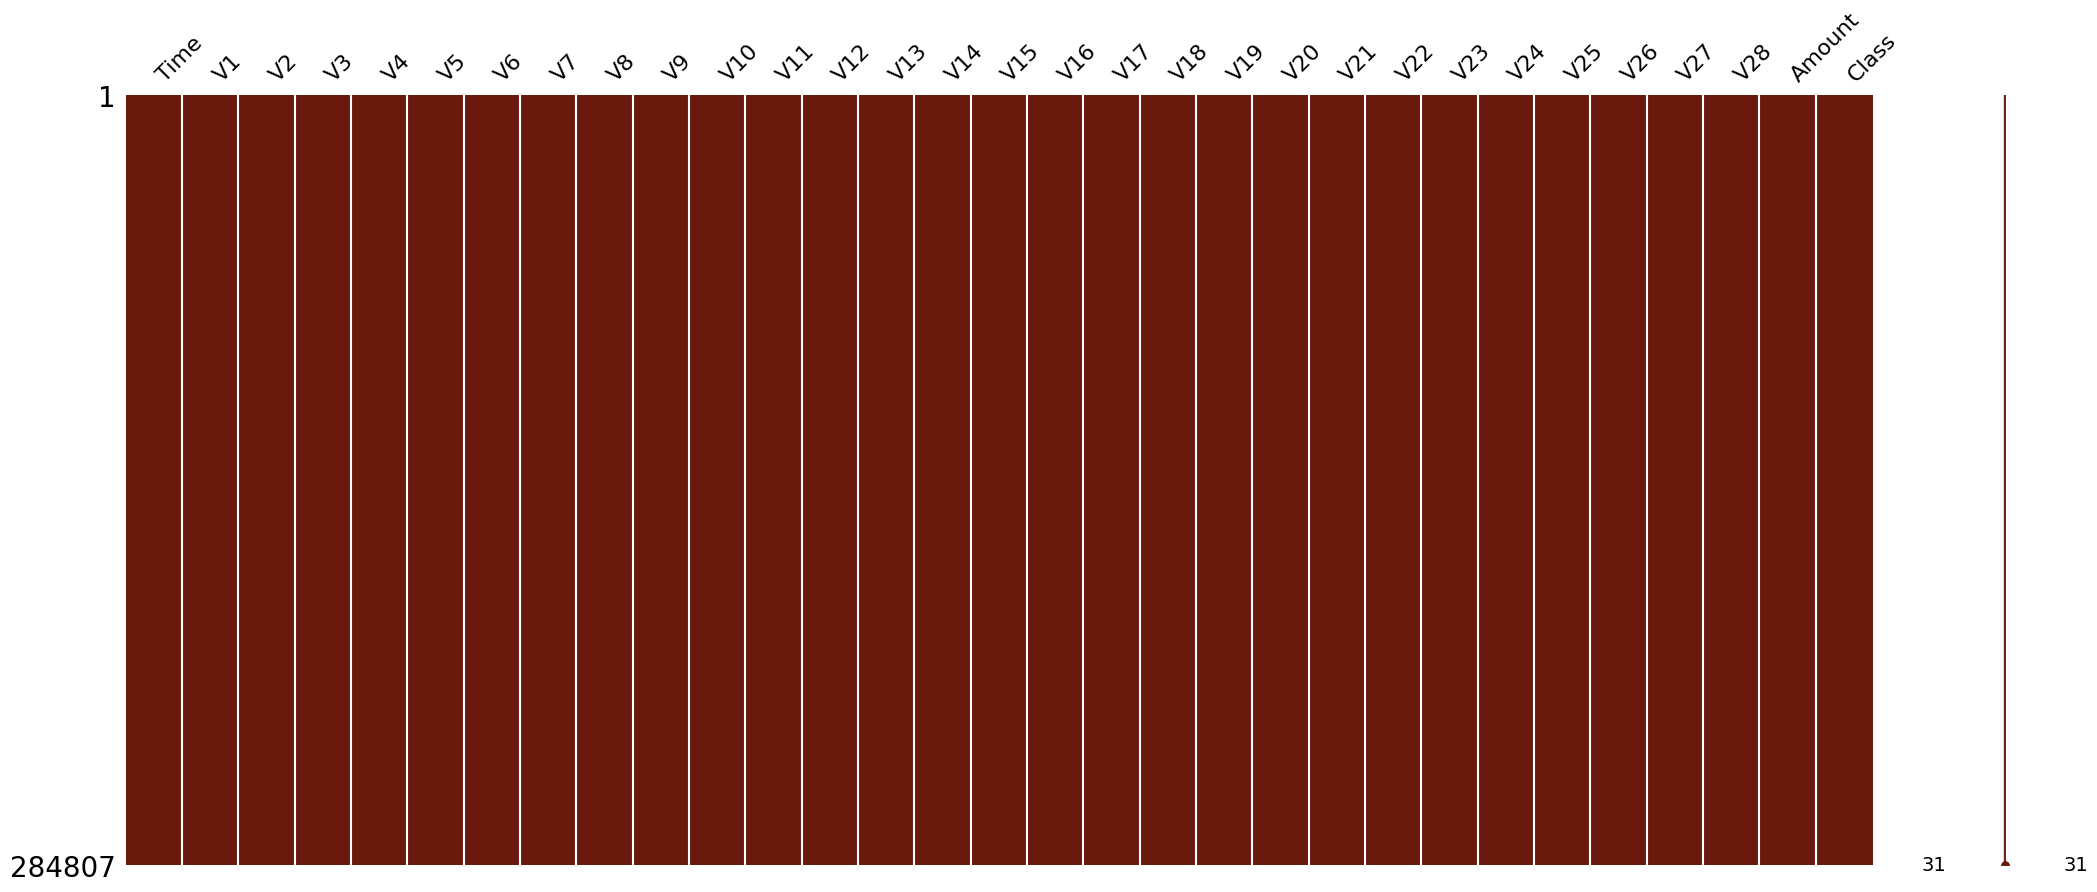

In [12]:
# Visualize the missing values using msno.matrix
msno.matrix(df,color=(0.42, 0.1, 0.05))
plt.show()

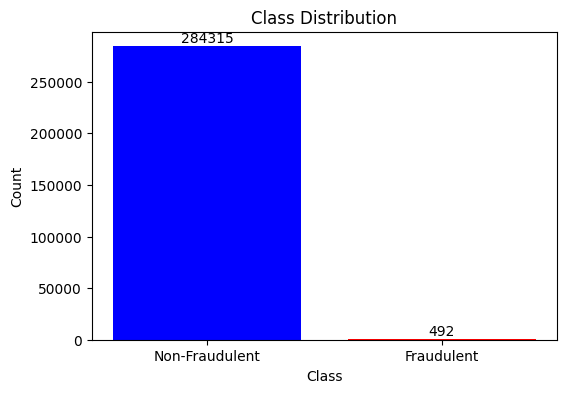

In [13]:
# Occurence of 0 and 1
class_counts = df['Class'].value_counts()


plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index.astype(str), class_counts.values, color=['blue', 'red'])

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1000, yval, ha='center', va='bottom', fontsize=10)

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'])


plt.show()

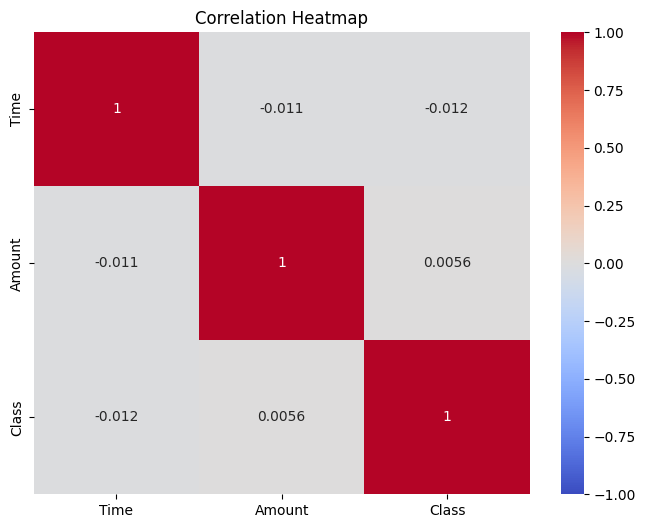

Correlation coefficients:
            Time    Amount     Class
Time    1.000000 -0.010596 -0.012323
Amount -0.010596  1.000000  0.005632
Class  -0.012323  0.005632  1.000000


In [14]:
correlation_matrix = df[['Time', 'Amount', 'Class']].corr()

# Plotting correlation matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Print correlation coefficients
print("Correlation coefficients:")
print(correlation_matrix)

In [15]:
#separate the feature columns and the label column
#converting them into a format suitable for use with machine learning algorithm
def preparation_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: label column
    """
    x = df.iloc[:, 2:30].values
    y = df.Class.values
    return x, y

In [16]:
# Define a function to create a scatter plot of our data and labels
#By visualizing the data, to see  how  fraud cases are scattered over the data
#It shows the distribution of fraud and non-fraud
def plot_df(x: np.ndarray, y: np.ndarray):
    plt.scatter(x[y == 0, 0], x[y == 0, 1], label="Non-Fraud", alpha=0.3, linewidth=0.1, c='g')
    plt.scatter(x[y == 1, 0], x[y == 1, 1], label="Fraud", alpha=0.3, linewidth=0.1, c='r')
    plt.legend()
    return plt.show()

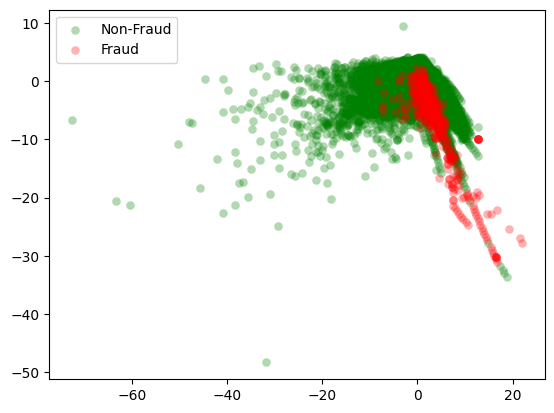

In [17]:
# Create x and y from the prep_data function
x, y = preparation_data(df)
# Plot our data by running our plot data function on X and y
plot_df(x, y)

# **DATA PREPROCESSING**

In [18]:
#Use of SMOTE to improve balancing in dataset
# Split the features and target variable
X = df.drop('Class', axis=1).values
y = df['Class']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution before and after SMOTE
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_resampled).value_counts())

Class distribution before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
Class distribution after SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


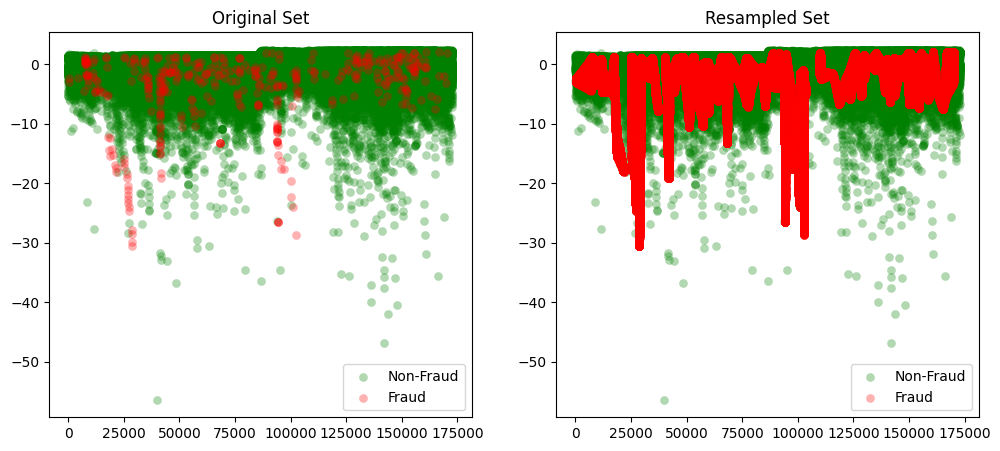

In [19]:
# Function to plot class distributions
def compare_plots(X, y, X_resampled, y_resampled, title1='Original Set', title2='Resampled Set'):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Non-Fraud", alpha=0.3, linewidth=0.15, c='g')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Fraud", alpha=0.3, linewidth=0.15, c='r')
    plt.title(title1)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Non-Fraud", alpha=0.3, linewidth=0.15, c='g')
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Fraud", alpha=0.3, linewidth=0.15, c='r')
    plt.title(title2)
    plt.legend()

    plt.show()

# Use the function to compare plots
compare_plots(X_train, y_train, X_train_resampled, y_train_resampled)

##**BASE MODEL TRAINING**

In [20]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# SVM Parameter Grid
svm_param_grid = {
    'C': [1, 10],
    'kernel': ['rbf']
    #'gamma': ['scale', 'auto']
}


# Logistic Regression Parameter Grid
lr_param_grid = {
    'C': [0.1, 1],
    'solver': ['liblinear']
}

#RFC Parameter Grid
RFC_param_grid = {'n_estimators': [1, 30],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']
}


#XGBoost Parameter Grid
XGB_param_grid = {
    'n_estimators': [50, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Initialize GridSearchCV
svm_grid_search = GridSearchCV(SVC(random_state=5), svm_param_grid, cv=3, scoring='recall', verbose=1, n_jobs=-1)
lr_grid_search = GridSearchCV(LogisticRegression(random_state=5), lr_param_grid, cv=3, scoring='recall', verbose=1, n_jobs=-1)
RFC_grid_search = GridSearchCV(RandomForestClassifier(random_state=5), RFC_param_grid, cv=3, scoring='recall', verbose=1, n_jobs=-1)
XGB_grid_search = GridSearchCV(XGBClassifier(random_state=5), XGB_param_grid, cv=3, scoring='recall', verbose=1, n_jobs=-1)

# Fit GridSearchCV
svm_grid_search.fit(X_train_scaled, y_train)
lr_grid_search.fit(X_train_scaled, y_train)
RFC_grid_search.fit(X_train_scaled, y_train)
XGB_grid_search.fit(X_train_scaled, y_train)

# Best Parameters and Model
print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)
print("Best parameters for Random Forest Classifier:", RFC_grid_search.best_params_)
print("Best parameters for XGBoost:", XGB_grid_search.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Best parameters for Random Forest Classifier: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 30}
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [22]:
#Evaluate the best models on the test set
#gives  the model that performed the best on the validation set
#during the grid search process, according to the scoring metric specified
svm_best = svm_grid_search.best_estimator_
lr_best = lr_grid_search.best_estimator_
RFC_best=RFC_grid_search.best_estimator_
XGB_best=XGB_grid_search.best_estimator_


print("Test Set Evaluation:")
print("SVM:", svm_best.score(X_test_scaled, y_test))
print("Logistic Regression:", lr_best.score(X_test_scaled, y_test))
print("RFC:", RFC_best.score(X_test_scaled, y_test))
print("XGBoost:", XGB_best.score(X_test_scaled, y_test))

Test Set Evaluation:
SVM: 0.999420666409185
Logistic Regression: 0.9991222218320986
RFC: 0.9995962220427653
XGBoost: 0.9995962220427653


In [23]:
# Using X_test_scaled as scaled features for the prediction set
y_pred_svm = svm_grid_search.best_estimator_.predict(X_test_scaled)
y_pred_lr = lr_grid_search.best_estimator_.predict(X_test_scaled)
y_pred_rfc = RFC_grid_search.best_estimator_.predict(X_test_scaled)
y_pred_xgb = XGB_grid_search.best_estimator_.predict(X_test_scaled)

In [24]:
#Print the classification report for the base models
class_report_svm = classification_report(y_test, y_pred_svm)
print("Classification Report SVM:\n", class_report_svm)

class_report_lr = classification_report(y_test, y_pred_lr)
print("Classification Report LR:\n", class_report_lr)

class_report_rfc = classification_report(y_test, y_pred_rfc)
print("Classification Report RFC:\n", class_report_rfc)

class_report_xgb = classification_report(y_test, y_pred_xgb)
print("Classification Report XGB:\n", class_report_xgb)

Classification Report SVM:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.69      0.80        98

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Classification Report LR:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Classification Report RFC:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93  

In [25]:
def print_cm(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    # Print confusion matrix
    print(f"\n{model_name} Confusion Matrix:")
    print(cm)

    # Visualize confusion matrix with default numerical labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f'{model_name} Confusion Matrix')

    # Custom labels
    labels = np.array([['TN', 'FP'], ['FN', 'TP']])

    # Adjust label positions
    label_positions = np.array([[(0.2, 0.8), (0.8, 0.8)], [(0.2, 0.2), (0.8, 0.2)]])

    for i in range(2):
        for j in range(2):
            ax.text(label_positions[i, j][0], label_positions[i, j][1], labels[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                    transform=ax.transAxes)

    plt.show()


SVM Confusion Matrix:
[[56861     3]
 [   30    68]]


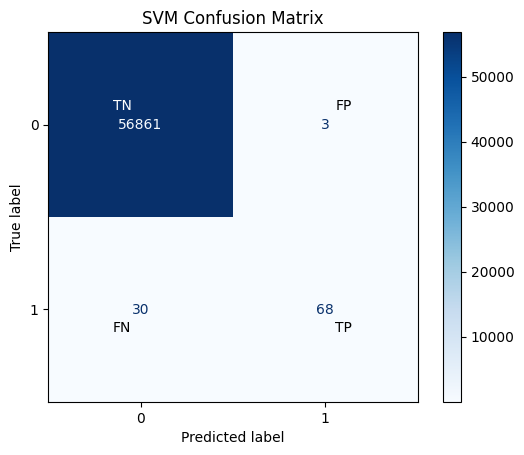


Logistic Regression Confusion Matrix:
[[56855     9]
 [   41    57]]


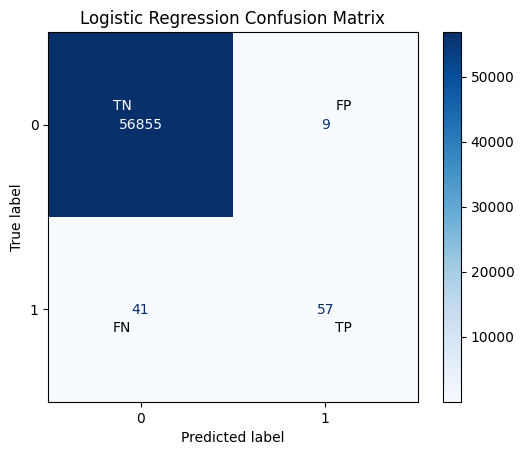


Random Forest Classifier Confusion Matrix:
[[56862     2]
 [   21    77]]


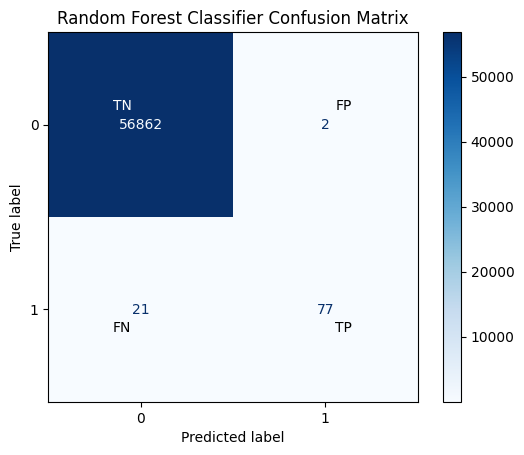


XGBoost Confusion Matrix:
[[56861     3]
 [   20    78]]


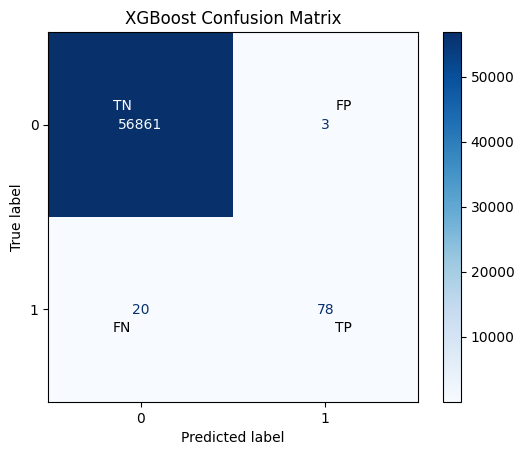

In [26]:
#Visualise the result
print_cm(y_test, y_pred_svm, "SVM")
print_cm(y_test, y_pred_lr , "Logistic Regression")
print_cm(y_test, y_pred_rfc , "Random Forest Classifier")
print_cm(y_test, y_pred_xgb , "XGBoost")

In [27]:
def specificity(y_test, y_preds, model_names):
    """
    Generating the classification report and calculating specificity for each model.

    Parameters:
    y_test (array-like): True labels
    y_preds (list of array-like): List of predicted labels from different models
    model_names (list of str): prediction of models names

    Returns:
    None: Prints the classification report and specificity for each model
    """
    for i, y_pred in enumerate(y_preds):
        print(f"\nClassification Report for {model_names[i]}:\n")
        print(classification_report(y_test, y_pred))

        # Create a variable for the cal
        #of the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Calculate specificity for each class
        specificity_per_class = {}
        for j, label in enumerate(np.unique(y_test)):
            tn = cm[j, j]
            fp = cm[:, j].sum() - cm[j, j]
            #formula for specificity
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
            specificity_per_class[label] = specificity

        # Calculate the average specificity for the model
        avg_specificity = np.mean(list(specificity_per_class.values()))

        # Print specificity
        print(f"Specificity for {model_names[i]}: {avg_specificity:.4f}\n")



# List of model names
model_names = ['SVM', 'Logistic Regression', 'Random Forest', 'XGBoost']

# Call the function with your models' predictions
specificity(
    y_test,
    [y_pred_svm, y_pred_lr, y_pred_rfc, y_pred_xgb],
    model_names
)



Classification Report for SVM:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.69      0.80        98

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Specificity for SVM: 0.9786


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Specificity for Logistic Regression: 0.9315


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79     

In [28]:
# Build the ANN model
model = Sequential()

# Hidden layers
model.add(Dense(units=64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Predict and create a confusion matrix
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)



Epoch 1/10
7121/7121 [==============================] - 21s 3ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 2/10
7121/7121 [==============================] - 22s 3ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9994
Epoch 3/10
7121/7121 [==============================] - 20s 3ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0036 - val_accuracy: 0.9994
Epoch 4/10
7121/7121 [==============================] - 19s 3ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 5/10
7121/7121 [==============================] - 20s 3ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0032 - val_accuracy: 0.9994
Epoch 6/10
7121/7121 [==============================] - 21s 3ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9994
Epoch 7/10
7121/7121 [==============================] - 18s 3ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0034 - val_ac

In [29]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[56855     9]
 [   21    77]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.79      0.84        98

    accuracy                           1.00     56962
   macro avg       0.95      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Average Specificity: 0.8928

ANN Confusion Matrix:
[[56855     9]
 [   21    77]]


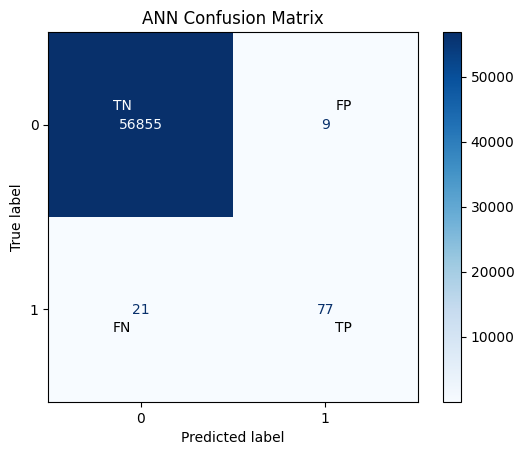

In [30]:
# Calculate specificity for each class
num_classes = conf_matrix.shape[0]
specificities = []

for i in range(num_classes):
    # True Negatives (TN) for class i
    tn = np.sum([conf_matrix[j, j] for j in range(num_classes) if j != i])
    # False Positives (FP) for class i
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Calculate the average specificity across all classes
avg_specificity = np.mean(specificities)


# Print average specificity
print(f"Average Specificity: {avg_specificity:.4f}")


# Generate and plot confusion matrix
print_cm(y_test, y_pred, "ANN")

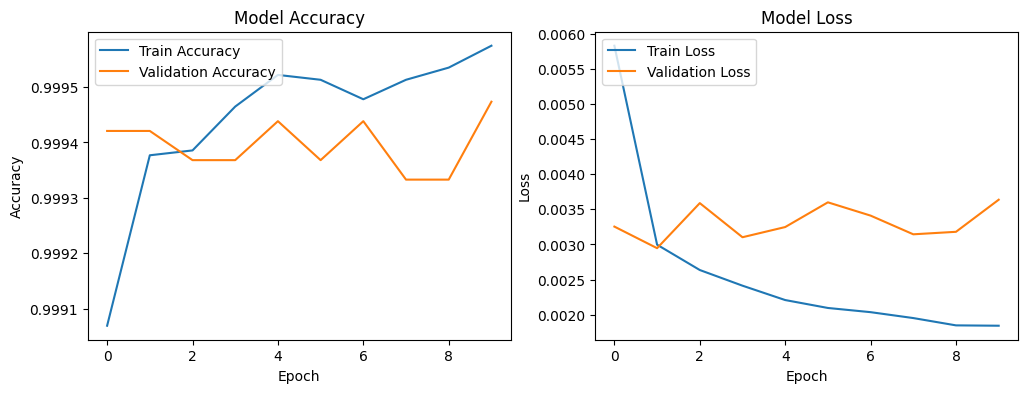

In [31]:
plt.figure(figsize=(12, 4))

#Plot the train and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [32]:
# Train traditional ML models
rf = RandomForestClassifier(class_weight={0: 1, 1: 12}, criterion='entropy', max_depth=12, max_features='log2', min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
rf.fit(X_train_scaled, y_train)

svc = SVC(C=10, kernel='rbf', probability=True, random_state=5)
svc.fit(X_train_scaled, y_train)


xgb = XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, random_state=5)
xgb.fit(X_train_scaled, y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=5, ...)

In [33]:
# Create the voting ensemble
voting_clf = VotingClassifier(estimators=[('svc', svc), ('rf', rf), ('XGB', xgb)], voting='soft',weights=[1, 2, 3])


#Train Ensemble
voting_clf.fit(X_train_scaled, y_train)

#Evaluate Model
y_pred = voting_clf.predict(X_test_scaled)




Voting Classifier Confusion Matrix:
[[56861     3]
 [   21    77]]


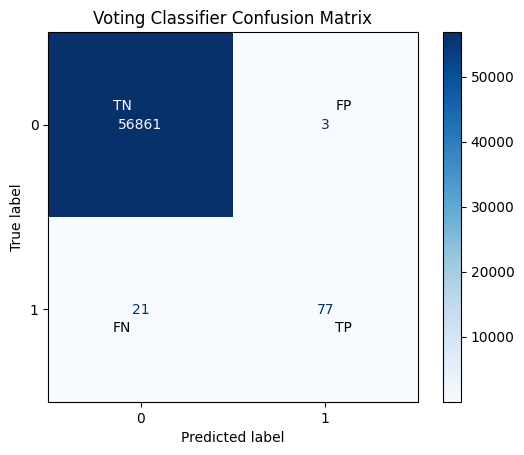

In [34]:
# Generate and plot confusion matrix
print_cm(y_test, y_pred, "Voting Classifier")

In [35]:
confu_matrix = confusion_matrix(y_test, y_pred)
# Calculate specificity for each class
num_classes = confu_matrix.shape[0]
specificities = []

for i in range(num_classes):
    # True Negatives (TN) for class i
    tn = np.sum([confu_matrix[j, j] for j in range(num_classes) if j != i])
    # False Positives (FP) for class i
    fp = np.sum(confu_matrix[:, i]) - confu_matrix[i, i]
    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Calculate the average specificity across all classes
avg_specificity = np.mean(specificities)

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Print average specificity
print(f"Average Specificity: {avg_specificity:.4f}")

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Average Specificity: 0.8928


In [36]:
# Get predicted probabilities
y_prob = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Find the threshold that gives the best balance between precision and recall
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall))]

# Apply the new threshold
y_pred_adjusted = (y_prob >= best_threshold).astype(int)




Threshold Confusion Matrix:
[[56861     3]
 [   18    80]]


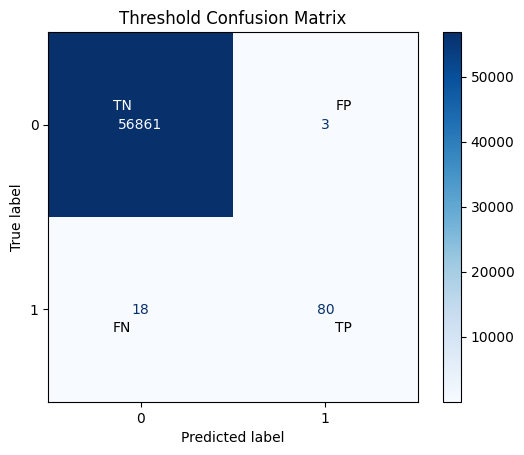

In [37]:
# Calculate confusion matrix for the threshold applied
print_cm(y_test, y_pred_adjusted, "Threshold")

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
# Calculate specificity for each class
num_classes = conf_matrix.shape[0]
specificities = []

for i in range(num_classes):
    # True Negatives (TN) for class i
    tn = np.sum([conf_matrix[j, j] for j in range(num_classes) if j != i])
    # False Positives (FP) for class i
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Calculate the average specificity across all classes
avg_specificity = np.mean(specificities)

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_adjusted))

# Print average specificity
print(f"Average Specificity: {avg_specificity:.4f}")

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.82      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Average Specificity: 0.9081


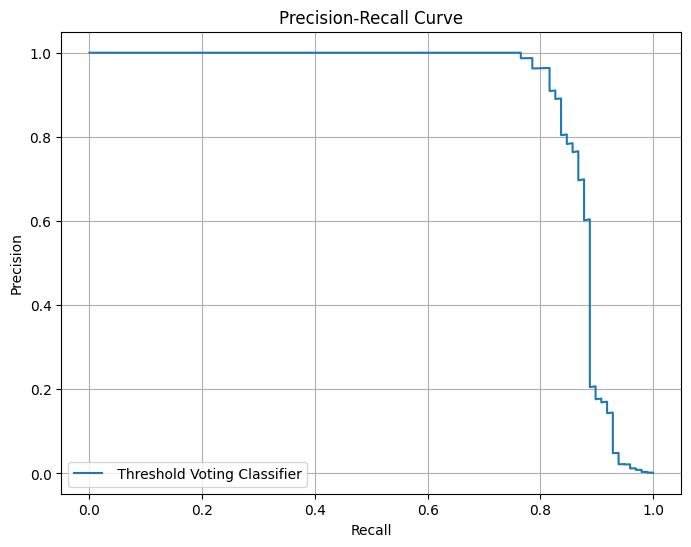

In [40]:
# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=' Threshold Voting Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()